In [1]:
from random import sample
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("probabilistic counts").getOrCreate()

clients_per_day = 1000

def get_n_distinct_integers(n):
  return sample(range(n*10), n)

def get_sample_day(day):
  return spark.createDataFrame(
    map(lambda x: (day, x), get_n_distinct_integers(clients_per_day)),
    ['day', 'client']
  )

def generate_data(days=7):
  out = get_sample_day(0)
  for day in range(1, days):
    out = out.unionAll(get_sample_day(day))
  
  return(out)

In [2]:
dd = generate_data()

In [3]:
from pyspark.sql.functions import approxCountDistinct, col

errors = (
  dd
  .groupBy('day')
  .agg(approxCountDistinct('client').alias('approx_count'))
  .orderBy('day')
  .withColumn('error', col('approx_count')/clients_per_day-1)
  .toPandas()
)

/home/harterrt/miniconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


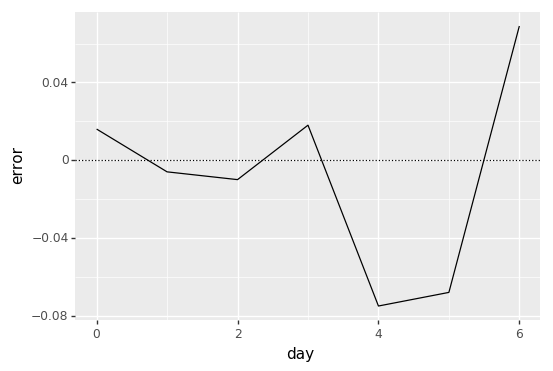

<ggplot: (8783375089969)>

In [4]:
from plotnine import ggplot, geom_line, geom_hline, aes

ggplot(errors, aes('day', 'error')) + geom_line() + geom_hline(yintercept=0, linetype='dotted')

In [5]:
errors

,day,approx_count,error
0,0,1016,0.016
1,1,994,-0.006
2,2,990,-0.010
3,3,1018,0.018
4,4,925,-0.075
5,5,932,-0.068
6,6,1069,0.069
